In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Measuring compute time
start = time.time()
pd.options.display.max_columns = None

This 'seperate_column' function is used to split the 'Genres' column to different columns for each unique genre. It follows these steps: First splits the column according to the ", " delimiter. Then keeps a record of each unique genre to create a new column for each of them by filling the values with 0. Lastly it iterates each row to update the values of the new columns according to the original column.

In [2]:
def seperate_column(df, columnName):
    
    # Splitting the values of the column on the ", " delimiter
    df[columnName] = df[columnName].str.split(', ')

    # Getting unique values
    unique_values = set()
    for values_list in df[columnName]:
        unique_values.update(values_list)

    # Creating a new column for each unique column and setting the value to 0
    for value in unique_values:
        df[value] = 0

    # Updating the new columns with necessary values (1,0)
    for index, row in df.iterrows():
        for value in row[columnName]:
            df.at[index, value] = 1

    # Droping the original column
    df.drop(columns=columnName, inplace=True)

    return df

This 'convert_to_minutes' function is used to convert the duration values in the 'Duration' column to minutes. It follows these steps: First converts all values to lowercase to prevent case insensitivity. Then splits the values by spaces and keeps a record of total hours and minutes. Lastly converts hours to minutes by multiplying with 60 and adds them together with minutes.

In [3]:
def convert_to_minutes(time_str):
    # Converting all values to lowercase to prevent case insensitivity
    time_str = time_str.lower()  

    hours = 0
    minutes = 0

    # Splitting the values by spaces
    parts = time_str.split()
    
    # Finding the values for hours and minutes
    for i in range(len(parts)):
        part = parts[i]
        if part == "hr" or part == "hour" or part == "hours":
            hours = int(parts[i - 1])
        elif part == "min" or part == "minute" or part == "minutes":
            minutes = int(parts[i - 1])

    # Calculating the total time in minutes
    total_minutes = hours * 60 + minutes

    return total_minutes

This 'KNNRegression' class is used to perform both k-NN and weighted k-NN operations for predicting the ratings of unseen users for desired k inputs. It has a 'fit', 'predict' and a helper method '_predict'.

fit:  This method is only used to keep the training data in memory.

predict:  This method takes the test input and gives it to the helper function to perform the calculations.

\_predict:  All the necessary calculations for knn are performed here. First it calculates the cosine similarity (The formula for cosine similarity is given below) of the user with the other users. Then according to these similarities it finds the most similar k users. If it is a weighted knn it first calculates the distances by reversing the similarities and then finds the weights of the k neighbours. By using these weights it calculates the predicted rating for the user. If it is not a weighted knn then it just takes the mean of the k neighbours as predicted rating for the user.

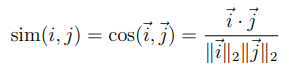


In [5]:
class KNNRegression:
    def __init__(self, k=5, weighted=False):
        self.k = k
        self.weighted = weighted

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = np.apply_along_axis(self._predict, 1, X)
        return y_pred

    def _predict(self, x):
        # Calculate cosine similarities between the input point and all training points
        similarities = np.dot(self.X_train, x) / (np.linalg.norm(self.X_train, axis=1) * np.linalg.norm(x))

        # Get the indices of the k-nearest neighbors and sort them
        k_indices = np.argpartition(similarities, -self.k)[-self.k:]

        # Get the target values of the k-nearest neighbors
        k_nearest_y = self.y_train[k_indices]

        if self.weighted:
            # Calculate weights based on the inverse of distances
            distances = 1 - similarities[k_indices]
            weights = 1 / (distances + 0.00000001) # A small number is added here to prevent division by zero

            # Return the weighted mean of the k-nearest neighbors' target values
            weighted_sum = np.sum(k_nearest_y * weights)
            weight_sum = np.sum(weights)
            return weighted_sum / weight_sum
        else:
            # Return the mean of the k-nearest neighbors' target values
            return np.mean(k_nearest_y)

This function is used to calculate the mean absolute error of the predicted ratings according to the actual ratings of the user by using the formula given below.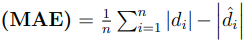

In [6]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

This 'cross_validation' function is used to perform k-fold cross-validation operations for the choosen knn model. For each fold it splits the data into training and validation sets and makes predictions by using the model to calculate the mean absolute error.

In [7]:
def cross_validation(model, X, y, k=5):

    fold_size = len(X) // k
    scores = []

    for i in range(k):
        # Spliting the data into training and validation sets for this fold
        X_train = np.concatenate((X[:i*fold_size], X[(i+1)*fold_size:]), axis=0)
        y_train = np.concatenate((y[:i*fold_size], y[(i+1)*fold_size:]))
        X_valid = X[i*fold_size:(i+1)*fold_size]
        y_valid = y[i*fold_size:(i+1)*fold_size]

        # Fiting the model on the training data
        model.fit(X_train, y_train)

        # Making predictions on the validation set
        y_pred = model.predict(X_valid)

        # Calculating the mean absolute error for this fold
        score = mean_absolute_error(y_valid, y_pred)
        scores.append(score)

    return scores

In [8]:
# Read anime data
anime_df = pd.read_csv("C:/Users/bayra/Desktop/Courses/AIN311/animes.csv")

# Drop "Name", "Studios" and "Image URL" columns
anime_df = anime_df.drop(columns=["Name", "Studios", "Image URL"])
anime_df.head()

,anime_id,Genres,Type,Source,Duration
0,1,"Action, Award Winning, Sci-Fi",TV,Original,24 min per ep
1,5,"Action, Sci-Fi",Movie,Original,1 hr 55 min
2,6,"Action, Adventure, Sci-Fi",TV,Manga,24 min per ep
3,7,"Action, Drama, Mystery, Supernatural",TV,Original,25 min per ep
4,8,"Adventure, Fantasy, Supernatural",TV,Manga,23 min per ep


In [9]:
# Read user data
user_rates_df = pd.read_csv("C:/Users/bayra/Desktop/Courses/AIN311/user_rates_train.csv")

# Drop "Username" and "Anime Title" columns
user_rates_df = user_rates_df.drop(columns=["Username", "Anime Title"])
user_rates_df.head()

,user_id,anime_id,rating
0,549,790,9
1,549,306,8
2,549,54,7
3,549,66,8
4,549,28805,9


In [10]:
# Read test data
test_rates_df = pd.read_csv("C:/Users/bayra/Desktop/Courses/AIN311/user_rates_test.csv")

# Drop "Username" and "Anime Title" columns
test_rates_df = test_rates_df.drop(columns=["Username", "Anime Title"])
test_rates_df.head()

,user_id,anime_id,rating
0,15885,2026,9
1,15885,120,10
2,15885,71,9
3,15885,72,10
4,15885,121,9


In [11]:
# Merge anime data and test data
df_test = pd.merge(anime_df, test_rates_df, on="anime_id")

# Merge anime data and user data
df = pd.merge(anime_df, user_rates_df, on="anime_id")
df.head()

,anime_id,Genres,Type,Source,Duration,user_id,rating
0,1,"Action, Award Winning, Sci-Fi",TV,Original,24 min per ep,549,10
1,1,"Action, Award Winning, Sci-Fi",TV,Original,24 min per ep,644,10
2,1,"Action, Award Winning, Sci-Fi",TV,Original,24 min per ep,2341,9
3,1,"Action, Award Winning, Sci-Fi",TV,Original,24 min per ep,3242,8
4,1,"Action, Award Winning, Sci-Fi",TV,Original,24 min per ep,3544,8


In [12]:
# Convert durations to minutes in test data
df_test["Duration"] = df_test["Duration"].apply(convert_to_minutes)

# Convert durations to minutes in train data
df["Duration"] = df["Duration"].apply(convert_to_minutes)
df.head()

,anime_id,Genres,Type,Source,Duration,user_id,rating
0,1,"Action, Award Winning, Sci-Fi",TV,Original,24,549,10
1,1,"Action, Award Winning, Sci-Fi",TV,Original,24,644,10
2,1,"Action, Award Winning, Sci-Fi",TV,Original,24,2341,9
3,1,"Action, Award Winning, Sci-Fi",TV,Original,24,3242,8
4,1,"Action, Award Winning, Sci-Fi",TV,Original,24,3544,8


In [13]:
# Get dummy variables for "Type" and "Source" columns in test data
df_test = pd.get_dummies(df_test, columns=["Type", "Source"], drop_first=True)

# Get dummy variables for "Type" and "Source" columns in train data
df = pd.get_dummies(df, columns=["Type", "Source"], drop_first=True)
df.head()

,anime_id,Genres,Duration,user_id,rating,Type_Music,Type_ONA,Type_OVA,Type_Special,Type_TV,Source_Book,Source_Card game,Source_Game,Source_Light novel,Source_Manga,Source_Mixed media,Source_Music,Source_Novel,Source_Original,Source_Other,Source_Picture book,Source_Radio,Source_Unknown,Source_Visual novel,Source_Web manga,Source_Web novel
0,1,"Action, Award Winning, Sci-Fi",24,549,10,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,"Action, Award Winning, Sci-Fi",24,644,10,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1,"Action, Award Winning, Sci-Fi",24,2341,9,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,"Action, Award Winning, Sci-Fi",24,3242,8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,"Action, Award Winning, Sci-Fi",24,3544,8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [14]:
# Seperate "Genres" column to different genre columns in test data
seperate_column(df_test, "Genres")

# Seperate "Genres" column to different genre columns in train data
seperate_column(df, "Genres")
df.head()

,anime_id,Duration,user_id,rating,Type_Music,Type_ONA,Type_OVA,Type_Special,Type_TV,Source_Book,Source_Card game,Source_Game,Source_Light novel,Source_Manga,Source_Mixed media,Source_Music,Source_Novel,Source_Original,Source_Other,Source_Picture book,Source_Radio,Source_Unknown,Source_Visual novel,Source_Web manga,Source_Web novel,Suspense,Supernatural,Sci-Fi,Action,Adventure,Hentai,Award Winning,Drama,Sports,Horror,Gourmet,Girls Love,Avant Garde,Slice of Life,Erotica,Romance,Ecchi,Fantasy,Mystery,Boys Love,Comedy,UNKNOWN
0,1,24,549,10,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,24,644,10,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,24,2341,9,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,24,3242,8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,24,3544,8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Since there are columns which are not presented in the test data, these missing columns are added manually
df_test.insert(loc=0,column="Type_Music",value=0)
df_test.insert(loc=0,column="Source_Book",value=0)
df_test.insert(loc=0,column="Source_Card game",value=0)
df_test.insert(loc=0,column="Source_Mixed media",value=0)
df_test.insert(loc=0,column="Source_Music",value=0)
df_test.insert(loc=0,column="Source_Picture book",value=0)
df_test.insert(loc=0,column="Source_Radio",value=0)
df_test.insert(loc=0,column="Source_Web novel",value=0)
df_test.insert(loc=0,column="UNKNOWN",value=0)
df_test.insert(loc=0,column="Hentai",value=0)

# Both train data and test data are sorted alphabetically to get the same order
df_test = df_test.sort_index(axis=1)
df = df.sort_index(axis=1)

In [16]:
# Test data is splitted into features and labels
df_test_Y = df_test.rating
df_test_X = df_test.drop(columns="rating")

# Train data is splitted into features and labels
df_Y = df.rating
df_X = df.drop(columns="rating")

In [17]:
# Performing 5-fold cross-validation for non-weighted k-values 3-5-7.
crossValMAE = []

for k_value in [3,5,7]:
    
    model = KNNRegression(k = k_value)
    scores = cross_validation(model, df_X, df_Y, k = 5)
    crossValMAE.append(scores)
    print(f"Average MAE for k={k_value}: {np.mean(scores)}")
    

Average MAE for k=3: 1.4239735278227985
Average MAE for k=5: 1.3610940032414913
Average MAE for k=7: 1.3343800648298219


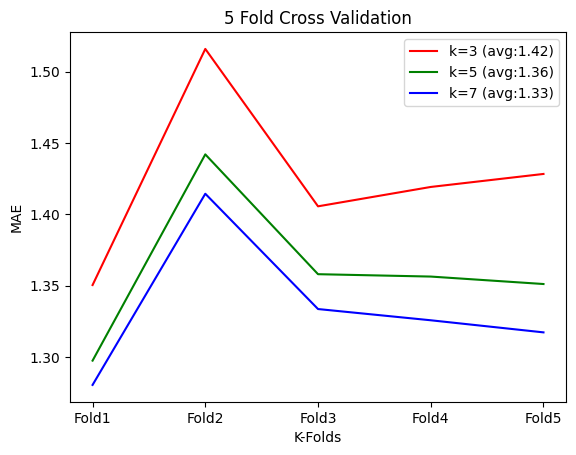

In [18]:
# Plotting the results of the validation
folds = ["Fold1","Fold2","Fold3","Fold4","Fold5"]
plt.plot(folds, crossValMAE[0], color='r', label=f"k=3 (avg:{np.round(np.mean(crossValMAE[0]),2)})")
plt.plot(folds, crossValMAE[1], color='g', label=f"k=5 (avg:{np.round(np.mean(crossValMAE[1]),2)})")
plt.plot(folds, crossValMAE[2], color='b', label=f"k=7 (avg:{np.round(np.mean(crossValMAE[2]),2)})")

plt.title("5 Fold Cross Validation")
plt.xlabel("K-Folds")
plt.ylabel("MAE")
plt.legend()
plt.show()

A 5-fold cross-validation is performed on the train data by using the knn model with k-values 3, 5 and 7. From the results of the validation test we can see that all these three models are making a peak at the 'Fold2' and a bottom at 'Fold1'. These results show us that the models we are using are giving us consistent results. We see that k3 gives an average error of 1.42 , k5 an error of 1.36 and k7 an error of 1.33. This shows us that the best option to predict the ratings of the unseen users would be a 7-NN model.

In [19]:
# Predicting the ratings for the users in the test dataset and calculating the MAE according to their actual ratings.
knn_mae = []

for k_value in [3,5,7]:
    model = KNNRegression(k = k_value)
    model.fit(df_X, df_Y)
    predict_Y = model.predict(df_test_X)
    error = mean_absolute_error(df_test_Y, predict_Y)
    knn_mae.append(error)
    print(f"Average MAE for k={k_value}: {error}")
    

Average MAE for k=3: 1.2991258076776893
Average MAE for k=5: 1.2426453819840366
Average MAE for k=7: 1.2314709236031927


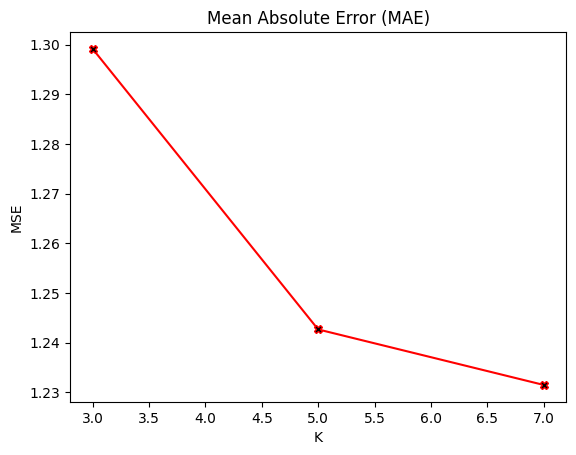

In [20]:
# PLotting the results of the prediction
plt.plot([3,5,7], knn_mae, color='r', marker='X', markerfacecolor='#000000')
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("K")
plt.ylabel("MSE")
plt.show()

After the 5-fold cross-validation test the models are used with the unseen test data to see their performance. As we have seen in the validation test the model performs best with the k value set to 7. However the model is performing better overall with unseen test data. As average error we get 1.29 for k3, 1.24 for k5 and 1.23 with k7

In [21]:
# Performing 5-fold cross-validation for weighted k-values 3-5-7.
crossValMAE = []

for k_value in [3,5,7]:
    
    model = KNNRegression(k = k_value, weighted=True)
    scores = cross_validation(model, df_X, df_Y, k = 5)
    crossValMAE.append(scores)
    print(f"Average MAE for k={k_value}: {np.mean(scores)}")




Average MAE for k=3: 1.4289239842051398
Average MAE for k=5: 1.3664604305738732
Average MAE for k=7: 1.3400507810924078


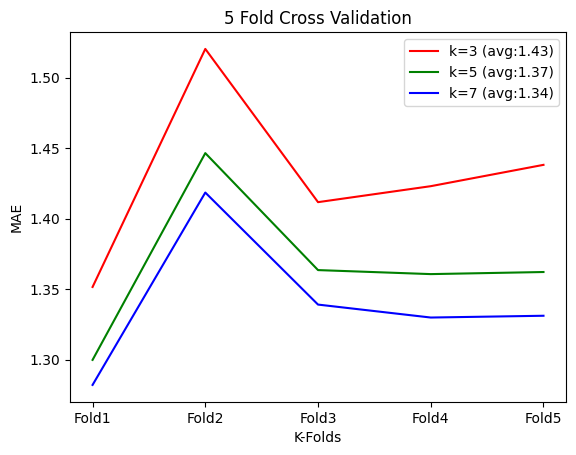

In [22]:
folds = ["Fold1","Fold2","Fold3","Fold4","Fold5"]
plt.plot(folds, crossValMAE[0], color='r', label=f"k=3 (avg:{np.round(np.mean(crossValMAE[0]),2)})")
plt.plot(folds, crossValMAE[1], color='g', label=f"k=5 (avg:{np.round(np.mean(crossValMAE[1]),2)})")
plt.plot(folds, crossValMAE[2], color='b', label=f"k=7 (avg:{np.round(np.mean(crossValMAE[2]),2)})")

plt.title("5 Fold Cross Validation")
plt.xlabel("K-Folds")
plt.ylabel("MAE")
plt.legend()
plt.show()

Again a 5-fold cross-validation is performed on the train data by using the knn model with k-values 3, 5 and 7 but this time with weights. From the results of the validation test we can see that all these three models are still making a peak at the 'Fold2' and a bottom at 'Fold1'. These results show us that the models we are using are giving us consistent results with weights aswell. However weighted kNN models are performing a little bit worse than non-weighted kNN models. This could be because getting the average of the neirest neighbours is maybe a better option than calculating the rating with respect to the distances to the neigbours. We see that k3 gives an average error of 1.45 , k5 an error of 1.39 and k7 an error of 1.36. This shows us that the best option to predict the ratings of the unseen users would be a 7-NN model.

In [23]:
# Predicting the ratings for the users in the test dataset with weights and calculating the MAE according to their actual ratings.
knn_mae = []

for k_value in [3,5,7]:
    model = KNNRegression(k = k_value, weighted=True)
    model.fit(df_X, df_Y)
    predict_Y = model.predict(df_test_X)
    error = mean_absolute_error(df_test_Y, predict_Y)
    knn_mae.append(error)
    print(f"Average MAE for k={k_value}: {error}")
    

Average MAE for k=3: 1.3001144093504036
Average MAE for k=5: 1.2473792533806811
Average MAE for k=7: 1.2370808452805968


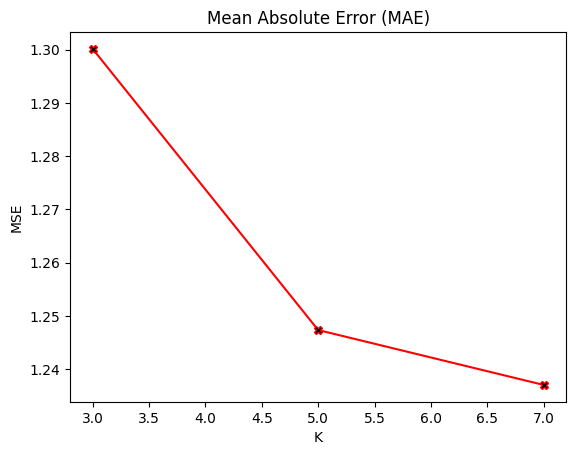

In [24]:
plt.plot([3,5,7], knn_mae, color='r', marker='X', markerfacecolor='#000000')
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("K")
plt.ylabel("MSE")
plt.show()

After the 5-fold cross-validation test with weights the models are used with the unseen test data to see their performance. As we have seen in the validation test the model performs best with the k value set to 7. Here the model is still performing better overall with unseen test data. As average error we get 1.36 for k3, 1.29 for k5 and 1.28 with k7. As conclusion we can say that the best option to predict the ratings of the unseen users would be a 7-neirest neighbours algorithm without taking the weights into account.

In [25]:
end = time.time()
print(f"Compute Time: {end-start}")

Compute Time: 3075.575459241867
